In [1]:
from spectrumtools.spectrum import Spectrum
from spectrumtools.generate_trapezoid_filter import generate_trapezoid_filter
from spectrumtools.analyze_waveform import plot_pulses, fit_tau, shape_waveform
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# Lab0.h5
# Source: Co-60


# invert pulses false, 500 trigger delay, 170 trigger threshold
f_name = 'data/calibration_data.h5'


f_data = h5py.File(f_name,'r')
raw_pulse_data = f_data['raw_data'][()]
raw_events = f_data['event_data'][()]
print(np.shape(raw_pulse_data))
_, unique_indices = np.unique(raw_events['timestamp'],return_index=True)
raw_pulse_data = np.int16(raw_pulse_data[unique_indices])
print(np.shape(raw_pulse_data))
source_energies = [661.7, 1173.228, 1332.492]

(78775, 5000)
(72143, 5000)


In [ ]:
plot_pulses(raw_pulse_data, 1)

Fitted Decay Constant Tau: 10562.064361088398


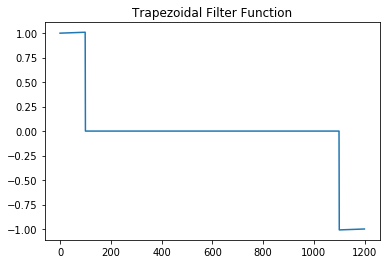

In [4]:
tau = fit_tau(raw_pulse_data[0])
print("Fitted Decay Constant Tau: {0}".format(tau))
k = 100
l = 1000
pre_trigger_delay = 1000


trap_filter = generate_trapezoid_filter(tau, k, l)
plt.figure()
plt.plot(trap_filter)
plt.title("Trapezoidal Filter Function")
plt.show()

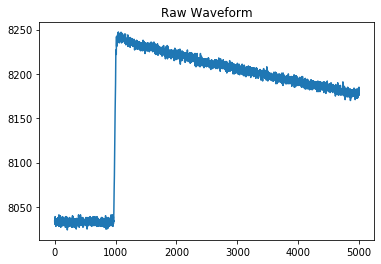

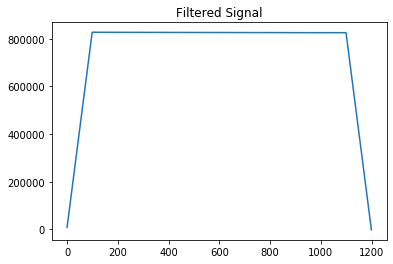

In [5]:
plt.figure()
plt.plot(raw_pulse_data[0])
plt.title("Raw Waveform")
plt.show()


integral, filtered_signal = shape_waveform(raw_pulse_data[0], trap_filter, k, pre_trigger_delay)

plt.figure()
plt.plot(filtered_signal)
plt.title("Filtered Signal")
plt.show()

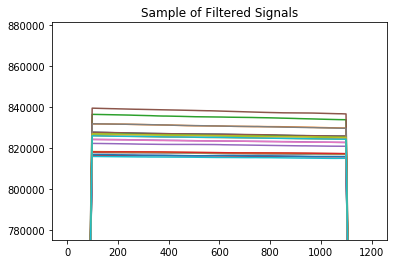

In [6]:

num_pulses = len(raw_pulse_data)
trapezoid_heights = np.zeros(num_pulses)

plt.figure()
for i in range( num_pulses ):
    trapezoid_heights[i], signal = shape_waveform(raw_pulse_data[i], trap_filter, k, pre_trigger_delay)
    if i < 20:
        plt.plot(signal)

plt.title("Sample of Filtered Signals")
plt.ylim((0.95*min(trapezoid_heights[:20]), 1.05*max(trapezoid_heights[:20])))
plt.show()

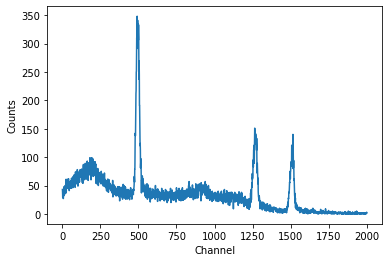

In [17]:
# Discard 0 valued pulses (waveform was anomalous)
spectrum_start = np.quantile(trapezoid_heights, 0.02)
# Ignore high outliers above 99.9th percentile (mostly noise)
spectrum_end = np.quantile(trapezoid_heights, 0.995)

number_of_bins = 2000

counts, bins = np.histogram(trapezoid_heights,
                            bins=number_of_bins, 
                            range=[spectrum_start, spectrum_end])
channels = np.arange(1, 1+len(counts))

plt.plot(channels, counts)
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.show()

In [8]:
binned_spectrum = Spectrum(counts)
source_energies = [661.7, 1173.228, 1332.492]
binned_spectrum.calibrate( source_energies, auto_calibrate=False , reset_calibration = True )

Opening plot for manual calibration...
What channel do you think the 661.7 keV gamma is in? 815
What channel do you think the 1173.228 keV gamma is in? 1458
What channel do you think the 1332.492 keV gamma is in? 1659
Energy(c) = -0.0c^2 + 0.8041c + 8.8698


array([-3.76211855e-06,  8.04084732e-01,  8.86983622e+00])

In [18]:
binned_spectrum.show_histogram("Calibrated Spectrum")